
# **Problemin Tanımı:**

**Mikroskop Görüntüleri için Hücre Segmentasyon Modeli**:

Mikroskop görüntüleri üzerinde hücre segmentasyonu yapmak için dijital görüntü işleme teknikleri kullanılmıştır.


# 1. Ön İşleme Aşamaları


Görüntü işleme için gerekli olan kütüphaneler import ediyoruz.

In [1]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import cv2

resize_img() fonksiyonu görüntüyü 1/4 oranında yeniden boyutlandırır. Buna ihtiyaç duymamızın sebebi üzerinde işlem yapacağımız mikroskop görüntülerin 2560x1920 gibi büyük boyutlarından dolayı resim ön işleme ve hücre segmentasyonu için çalışan algoritmaların yavaş çalışmasıdır. Bunun yardımı ile hücreleri daha hızlı tespit edebiliyoruz.

In [2]:
def resize_img(img):
  new_width = int(img.shape[1]*1/4)
  new_height = int(img.shape[0]*1/4)
  return cv2.resize(img, (new_width, new_width), interpolation=cv2.INTER_CUBIC)

Mikroskop görüntüsünü açıp BGR renk paletinden RGB'ye çeviriyoruz.

In [3]:
# Diğer resimler üzerinde test etmek için image_name'i değiştirmek yeterlidir.
image_name = "cell_00006"
path = "DB"

# Resim Yolu
image_path = f"{path}\\{image_name}.bmp"

# Resmi okuma
img = cv2.imread(image_path)

# Yeniden Boyutlandırma
img = resize_img(img)

# BGR'den RGB'ye dönüştürme (Matplotlib'in varsayılanı RGB'dir)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Gürültü Eliminasyonu:
Aşağıda 3 farklı teknik farklı paramametreler ile test edilmiştir. Bilateral bazı mikroskop resimlerinde iyi biçimde çalışsa da hücrelerin yoğun ve iç içe girdiği görüntülerde kenarları kaybetmektedir. Bizim amacımız olabildiğince noktasal içerğin kaybolması ve hücrelerin renklerini diğer aşamalar için yumuşatmak. Açık ara en iyisi Median Blur tekniğidir. Bu teknik yoğun noktasal gürültüleri etkili bir şekilde azaltır. Kenarları koruma konusunda daha iyidir. Genellikle mikroskop görüntüleri gibi yüksek çözünürlüklü, detaylı ve küçük noktasal parçacıkların çok olduğu yapılarda en etkili sonuçları verir, çünkü hem gürültüyü azaltır hem de kenarları korur.

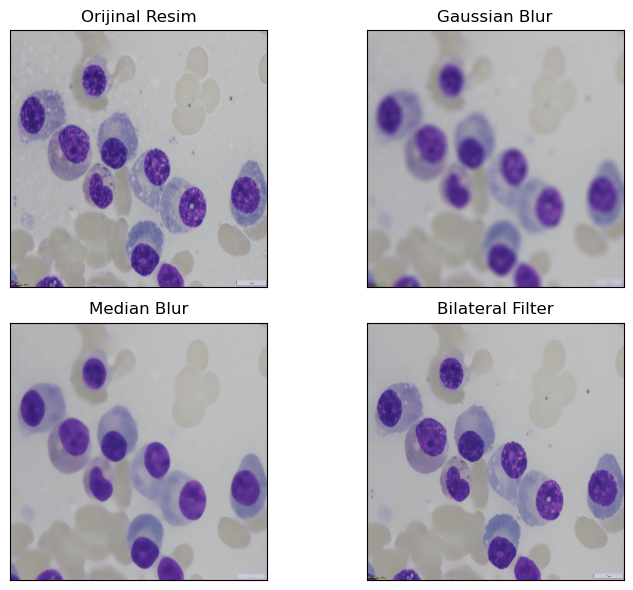

In [4]:
# Gaussian Blur
gaussian_blur = cv2.GaussianBlur(img, (13, 13), 15)

# Median Blur
median_blur = cv2.medianBlur(img, 13)

# Bilateral Filter
bilateral_filter = cv2.bilateralFilter(img, 25, 25, 40)

# Diğer aşamalar için median_blur içerğini kopyalıyoruz.
img_blur = median_blur.copy()

# Görüntüleri yan yana gösterme
# 2 satır, 2 sütunluk bir subplot oluşturma
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Resimleri subplotlara yerleştirme
axs[0, 0].imshow(img)
axs[0, 1].imshow(gaussian_blur)
axs[1, 0].imshow(median_blur)
axs[1, 1].imshow(bilateral_filter)

# Resimlere başlık verme
axs[0, 0].set_title('Orijinal Resim')
axs[0, 1].set_title('Gaussian Blur')
axs[1, 0].set_title('Median Blur')
axs[1, 1].set_title('Bilateral Filter')

# Eksen isimlerini kaldırma (isteğe bağlı)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])

# Görüntüyü gösterme
plt.tight_layout()
plt.show()

## Normalizasyon

Farklı normalizasyon yöntemleri denenmiş ve proje için en uygun olanı Min-Max normalizasyon olduğu tespit edilmiştir. Bir görüntüdeki piksel değerlerini 0 ile 255 arasına sıkıştırarak, görüntünün genel parlaklık dağılımını yeniden düzenler. Bu işlem, görüntüdeki kontrastı dengeleyebilir, çünkü orijinaldeki düşük ve yüksek parlaklık değerleri daha eşit bir aralığa yayılır. Sonuç olarak, daha homojen bir aydınlık seviyesi elde edilir. Bir sonraki aşamada hücre çeperi ile çekirdeği yüksek oranda birlikte tespit etmek için önemli bir adımdır.

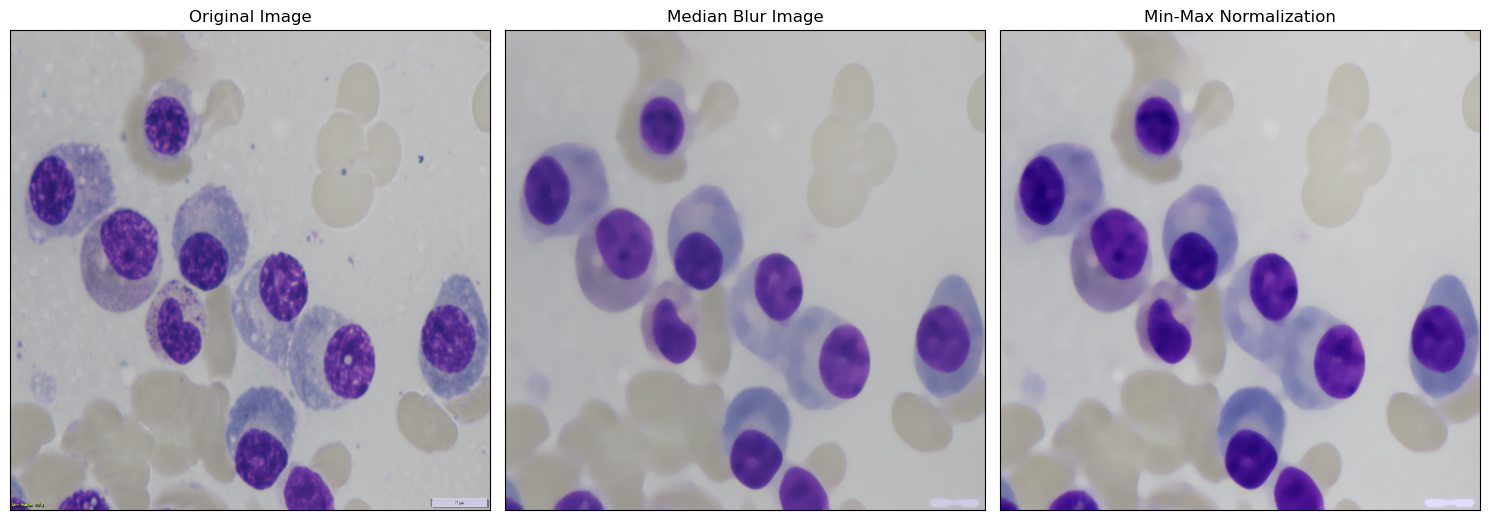

In [5]:
# Min-Max Normalization
norm_image = cv2.normalize(img_blur, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Görüntüleri yan yana gösterme
# 2 satır, 2 sütunluk bir subplot oluşturma
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Resimleri subplotlara yerleştirme
axs[0].imshow(img)
axs[1].imshow(img_blur)
axs[2].imshow(norm_image)

# Resimlere başlık verme
axs[0].set_title('Original Image')
axs[1].set_title('Median Blur Image')
axs[2].set_title('Min-Max Normalization')

# Eksen isimlerini kaldırma (isteğe bağlı)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])

# Görüntüyü gösterme
plt.tight_layout()
plt.show()

## Histogram eşitleme

Normalize edilmiş görüntünün hücrelerin çekirdeğini ve çeperini belirli bir tona getirdik. Görüntüdeki parlaklık ve kontrast dengesizliklerini gidermek için histogram eşitleme kullanılmıştır. LAB renk uzayında histogram eşitleme, tespit etmek istedğimiz hücreleri belirginleştiren en iyi yöntemdir. Renkli görüntüyü LAB renk uzayına dönüştürüp sadece parlaklık kanalı (L) üzerinde histogram eşitleme yaparak tespit etmek istedğimiz hücrenin çeperi ve çekirdeğini aynı renk tonuna getiririz. Bu şekilde hücre tespiti sırasında çekirdek ve çeperi birlikte tespit etmek amaçlanmıştır.

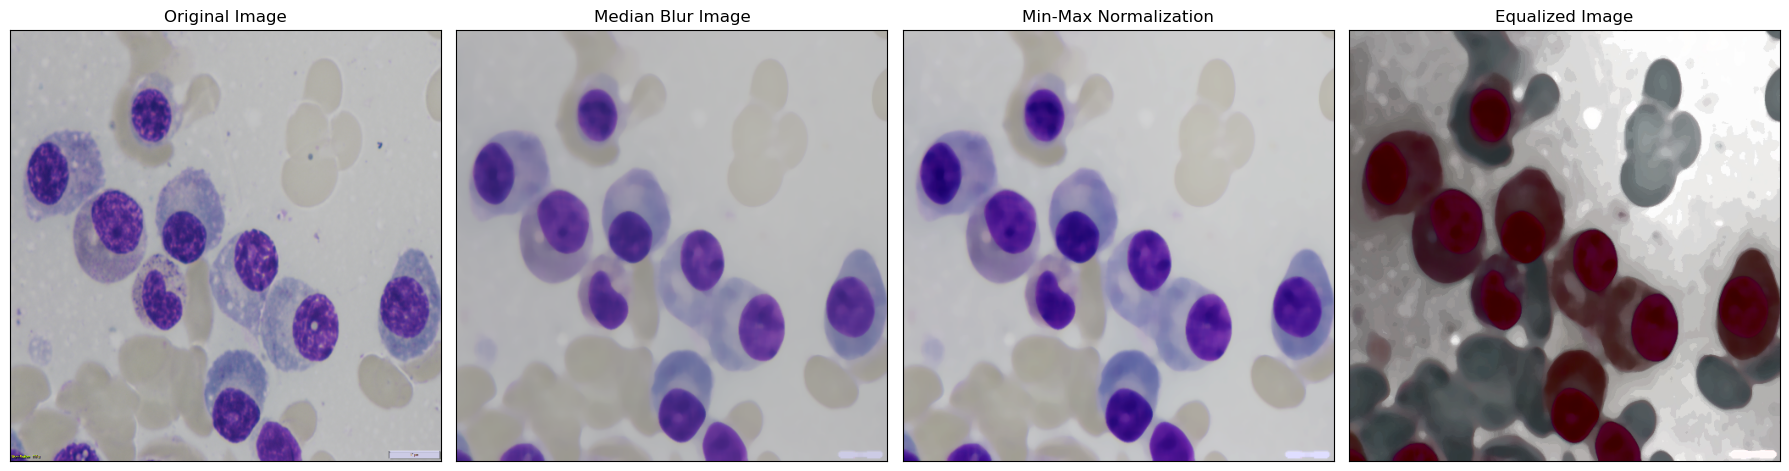

In [6]:
# LAB Renk Uzayında Histogram Eşitleme
lab_image = cv2.cvtColor(norm_image, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab_image)

# Histogram Eşitleme sadece L kanalına uygulanır
l_equalized = cv2.equalizeHist(l)

# Kanalları birleştirip geri BGR formatına dönüştürme
lab_equalized = cv2.merge((l_equalized, a, b))
equalized_image = cv2.cvtColor(lab_equalized, cv2.COLOR_LAB2RGB)


# Görüntüleri yan yana gösterme
# 2 satır, 2 sütunluk bir subplot oluşturma
fig, axs = plt.subplots(1, 4, figsize=(18, 6))

# Resimleri subplotlara yerleştirme
axs[0].imshow(img)
axs[1].imshow(img_blur)
axs[2].imshow(norm_image)
axs[3].imshow(equalized_image)

# Resimlere başlık verme
axs[0].set_title('Original Image')
axs[1].set_title('Median Blur Image')
axs[2].set_title('Min-Max Normalization')
axs[3].set_title('Equalized Image')

# Eksen isimlerini kaldırma (isteğe bağlı)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])

# Görüntüyü gösterme
plt.tight_layout()
plt.show()

# 2.Hücre Tespiti

Histogram eşitleme ile hücrelerin çekirdeğini ve çeperini belirli bir renk tonuna getirmeniz, hücre tespitinde renk tabanlı segmentasyon için çok faydalı olacaktır. Bu durumda, bordo tonunu kullanarak hücreleri tespit etmek işimizi kolaylaştırabilir fakat bu yöntemin bazı problemleri vardır. Tanımlanan renk aralığına giren her bir cismin tespiti yapılacaktır. Bu durumda istenmeyen gürültüler de tespit edilecektir. Aynı zamanda bazı hücre kısımları düzgün bir biçimde tespiti yapılamamaktadır. Bazı mikroskop görüntülerinde yüksek oranda doğru tespit edilebilmişse de her bir hüre görüntüsünde işe yaramamaktadır. Bu yöntem aşağıda denenmiştir.

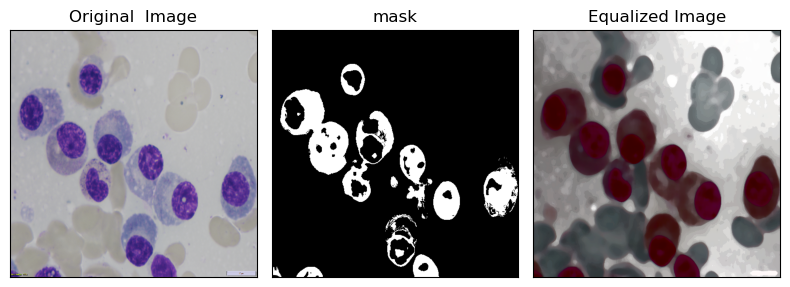

In [7]:
# HSV renk uzayına dönüştürme
hsv_image = cv2.cvtColor(equalized_image, cv2.COLOR_RGB2HSV)

# Bordo rengi için HSV aralığı
lower_bordo = np.array([140, 120, 0])
upper_bordo = np.array([220, 255, 120])

# Bordo tonunu maskeleme
mask = cv2.inRange(hsv_image, lower_bordo, upper_bordo)


# Maskenin 3 kanala dönüştürülmesi
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

# Görüntüleri yan yana gösterme
# 2 satır, 2 sütunluk bir subplot oluşturma
fig, axs = plt.subplots(1,3, figsize=(8, 6))

# Resimleri subplotlara yerleştirme
axs[0].imshow(img)
axs[1].imshow(mask, cmap = "gray")
axs[2].imshow(equalized_image)

# Resimlere başlık verme
axs[0].set_title('Original  Image')
axs[1].set_title('mask')
axs[2].set_title('Equalized Image')

# Eksen isimlerini kaldırma (isteğe bağlı)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])

# Görüntüyü gösterme
plt.tight_layout()
plt.show()

Farklı görüntülerde test edildikten sonra istenilen sonuca ulaşılamadığı için daha sorna görüntü segmentasyonu için sıkça kullanılan GMM (Gaussian Mixture Model) adı verilen bir istatistiksel yöntem kullanılmıştır. GMM, bir veri setinin (bizim senaryo için mikroskop görüntüleri), genellikle farklı sınıflara ait olan alt gruplarını modellemek için birden fazla Gauss dağılımını kullanır. Hücre segmentasyonu gibi bir senaryoda, GMM’i kullanarak hücreleri farklı sınıflara (örneğin hücre çekirdeği, diğer cisimler, arka plan) ayırabiliriz.

In [8]:
# HSV renk uzayına dönüştür
hsv_image = cv2.cvtColor(equalized_image, cv2.COLOR_BGR2HSV)

h, w, _ = equalized_image.shape

# HSV renk kanallarını ve piksel koordinatlarını birleştir
X = hsv_image.reshape(-1, 3)  # Renk özellikleri

# GMM modelini tanımla (örneğin 3 sınıf: hücre, diğer hücreler, arka plan)
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)

# Modeli eğit
gmm.fit(X)

GaussianMixture(n_components=3, random_state=42)

GMM modeli ile mikroskop göüntüsü 3 sınıfa ayrılmıştır. Hücre dokusunu tespit edilidği sınıf dinamik olarak bu 3 sınıf arasından seçilmelidir. Yanlış bir sınıf seçilmesi durumunda hücrelerin aksine arka plan ya da istenmeyen görüntülerin tespiti yapılabilir. Dinamik olarak sınıf tespiti yapmak için sınfların ortalama renkleri analiz edilip hücreleri tespit eden sınıfın hedef rengi bulunmuştur. Euclidean mesafesi hesaplanmış ve hedef renge en yakın sınıf indexi seçilmiştir. Sınıf ortalama renkleri ve seçilen sınıfın indexi aşağıda yazdırılmıştır.

Sınıf Ortalama Renkleri (Mu):
[[ 78.72445659  16.53011465 124.06557429]
 [126.15596757 175.40255624  70.95084454]
 [ 56.46772498   1.94863638 209.05326352]]
core_class 1


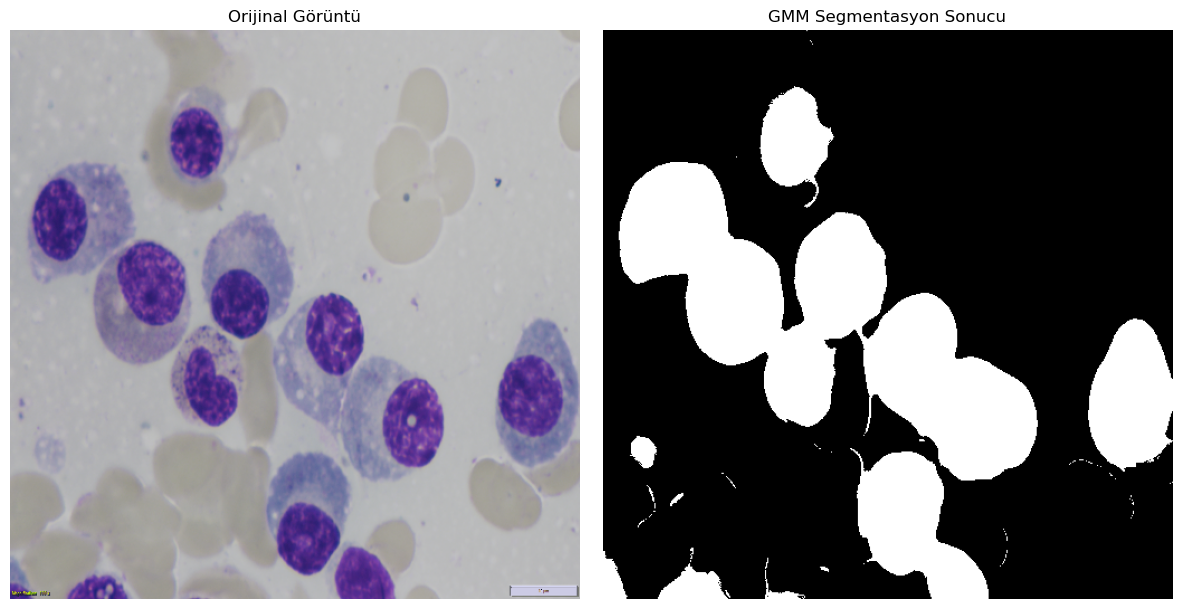

In [9]:
# Her pikselin sınıfını tahmin et
labels = gmm.predict(X)

# Renk ortalaması (hedef renk)
target_color = np.array([126.49791953, 255.0, 70.80896763])

# Modelin her sınıfının ortalama rengini al
means = gmm.means_

# Ortalama renkleri yazdır
print("Sınıf Ortalama Renkleri (Mu):")
print(means)

# Euclidean mesafesini hesapla
distances = np.linalg.norm(means - target_color, axis=1)

# En yakın sınıfın indeksini bul
core_class = np.argmin(distances)
print("core_class", core_class)

# Sonuçları yeniden görüntü boyutuna dönüştür
segmented_image = labels.reshape(h, w)

# Çekirdek sınıfını seç (örneğin sınıf 1)
gmm_mask = (segmented_image == core_class).astype(np.uint8) * 255

# Görselleştirme
plt.figure(figsize=(12, 6))

# Orijinal görüntü
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Orijinal Görüntü")
plt.axis("off")

# Segmentasyon sonucu
plt.subplot(1, 2, 2)
plt.imshow(gmm_mask.astype(np.uint8), cmap="gray")
plt.title("GMM Segmentasyon Sonucu")
plt.axis("off")

plt.tight_layout()
plt.show()

# 3.Morfolojik İşlemler

Sonraki adımda, morfolojik işlemler uygulanır. Morfolojik işlemler, bir görüntü üzerinde belirli şekilleri manipüle etmek için kullanılır. Açma (Opening) ve Kapama (Closing) işlemleri kullanılmıştır. İlk olarak Açma, gürültüyü ve küçük nesneleri ortadan kaldırır. Sonra Kapama, bu temizlenmiş görüntüyü daha düzgün hale getirir ve küçük boşlukları doldurur.

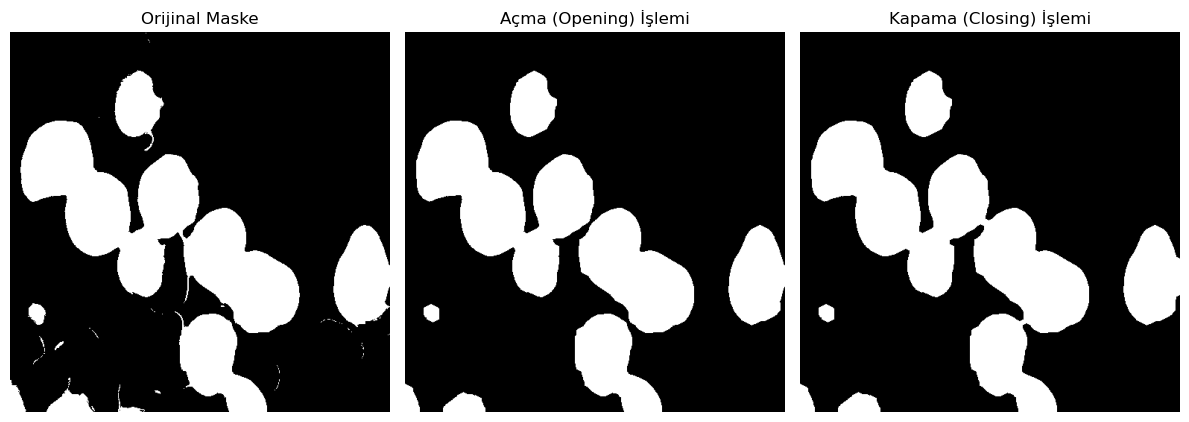

In [10]:
# Gmm ile sınıflandırılan hücrelerin maskesini kopyala
mask = gmm_mask.copy()

# Morfolojik çekirdek oluşturma
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Çekirdek boyutu 5x5

# Açma işlemi (Opening)
opened = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=4)

# Kapama işlemi (Closing)
closed = cv2.morphologyEx(opened.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=2)

# Sonuçları görselleştirme
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(mask, cmap="gray")
plt.title("Orijinal Maske")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(opened, cmap="gray")
plt.title("Açma (Opening) İşlemi")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(closed, cmap="gray")
plt.title("Kapama (Closing) İşlemi")
plt.axis("off")

plt.tight_layout()
plt.show()


Açma ve kapama işlemleri sonucunda elde edilen maskeyi daha iyi bir hale getirebilmek için maske görüntüsü üzerindeki boşlukları doldurmak için "flood fill" algoritmasını kullanılır. Bunun yanında dış kenarları sıfırlayarak işlemi maskenin sadece iç kısmına uygular. Sonuç olarak tespit edilen hücrelerin içerisinde boşluk varsa onları maskeye uygun beyaz renk ile doldurur.

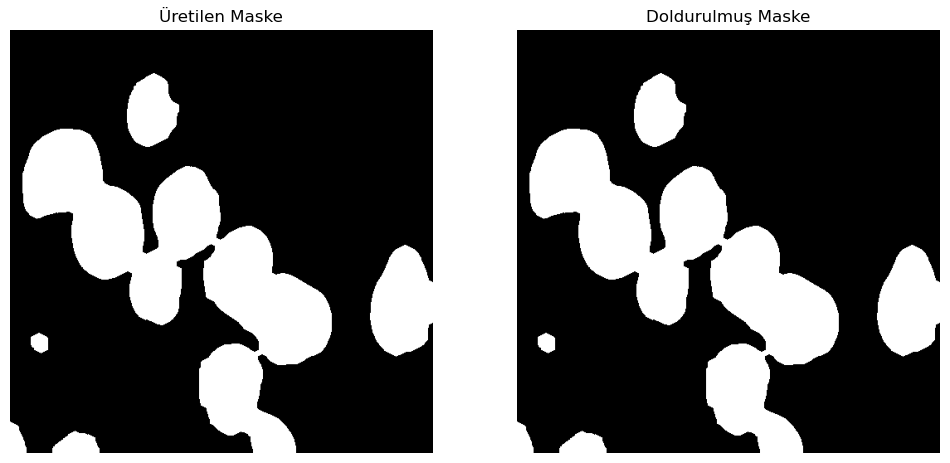

In [11]:
# Flood fill için bir kopya oluştur ve dış çerçeveyi beyaz yap
filled_mask = closed.copy()

# Kenarları beyaz yapın (dış çerçeveyi)
filled_mask[0, :] = 0
filled_mask[-1, :] = 0
filled_mask[:, 0] = 0
filled_mask[:, -1] = 0

h, w = filled_mask.shape
cv2.floodFill(filled_mask, None, (0, 0), 255)  # (0,0) başlangıç noktası

# Dıştaki alanları ters çevir ve orijinal maskeyle birleştir
filled_holes = cv2.bitwise_or(closed, cv2.bitwise_not(filled_mask))


# Görselleştirme
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(closed, cmap="gray")
plt.title("Üretilen Maske")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(filled_holes, cmap="gray")
plt.title("Doldurulmuş Maske")
plt.axis("off")

plt.show()

# 4.Maskeyi Orijinal Resme Uygulama ve Kenarları Tespit Etme

Üretilmiş maskeyi orijinal resme uygulayıp daha sonra Canny yöntemiyle kenarları tespit edip hücreleri görselleştiriyoruz.

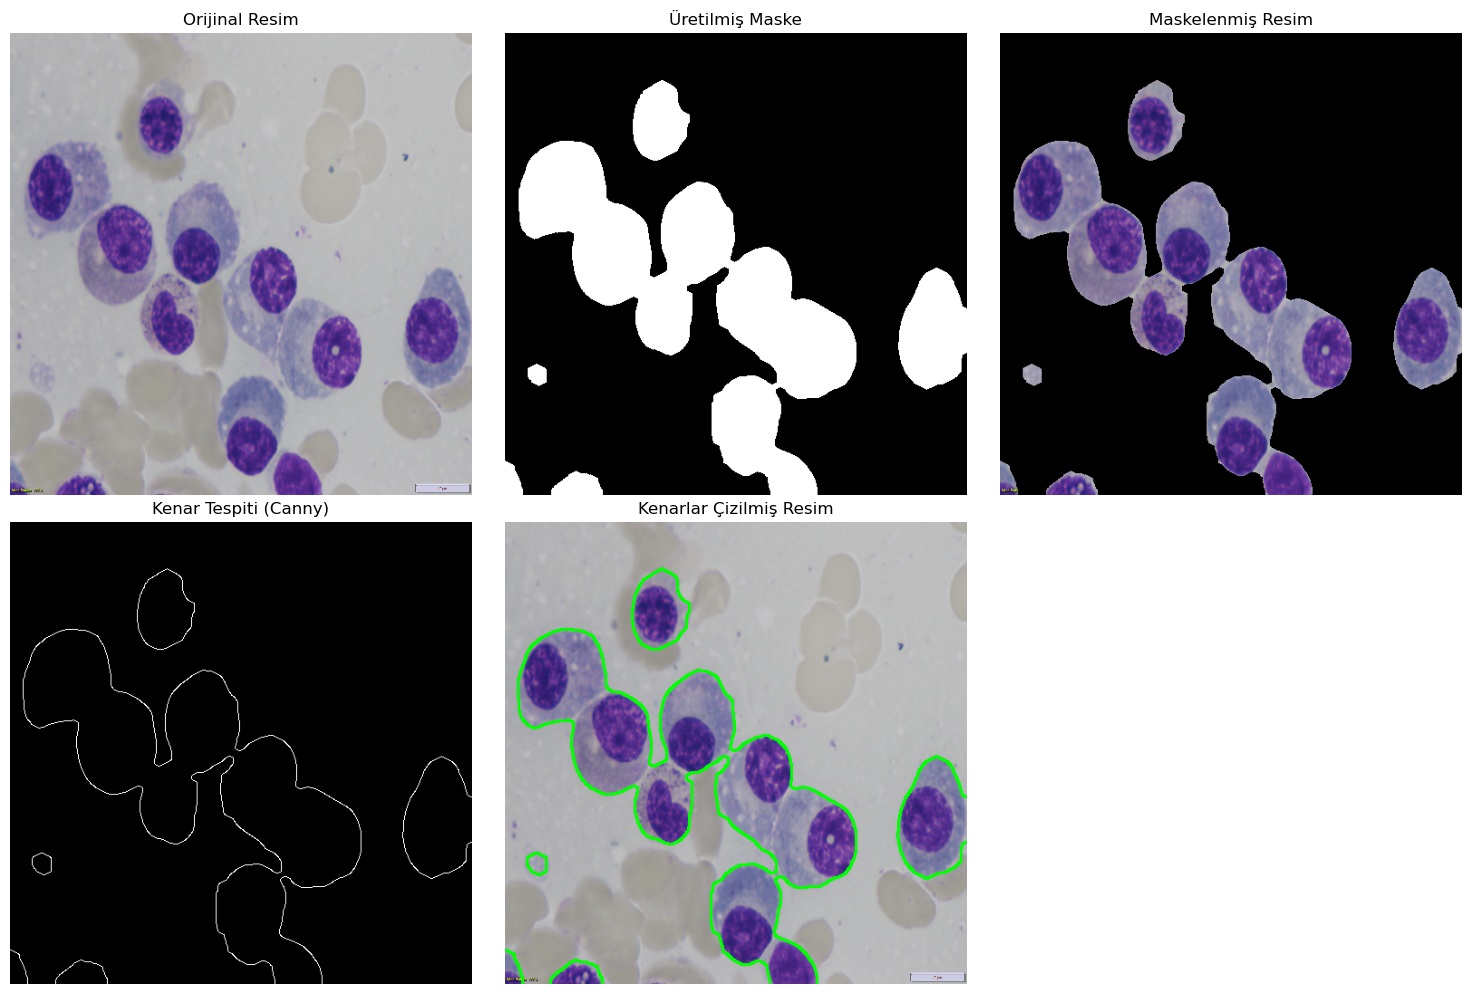

In [12]:
# Maskenin boyutunu orijinal resimle uyumlu hale getir
mask_resized = cv2.resize(filled_holes, (img.shape[1], img.shape[0]))

# Maskeyi orijinal resme uygula
masked_image = cv2.bitwise_and(img, img, mask=mask_resized)

# Kenarları tespit et (Canny yöntemiyle)
edges = cv2.Canny(mask_resized, 100, 200)

# Kenarları orijinal resim üzerinde çiz
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = img.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)  # Yeşil renk ile kenarları çiz

# Görselleştirme
plt.figure(figsize=(15, 10))

# 1. Orijinal resim
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title("Orijinal Resim")
plt.axis('off')

# 2. Üretilmiş Maske
plt.subplot(2, 3, 2)
plt.imshow(filled_holes, cmap='gray')
plt.title("Üretilmiş Maske")
plt.axis('off')

# 3. Yeniden boyutlandırılmış maske
plt.subplot(2, 3, 3)
plt.imshow(masked_image)
plt.title("Maskelenmiş Resim")
plt.axis('off')

# 4. Maskelenmiş resim
plt.subplot(2, 3, 4)
plt.imshow(edges, cmap='gray')
plt.title("Kenar Tespiti (Canny)")
plt.axis('off')

# 5. Kenar tespiti
plt.subplot(2, 3, 5)
plt.imshow(image_with_contours)
plt.title("Kenarlar Çizilmiş Resim")
plt.axis('off')

plt.tight_layout()
plt.show()

# 5.Test Aşaması

Yukarıda uygulanan her bir işlemi kolay bir şekilde resim üzerinde uygulamak için kullanılan bir fonksiyon.

In [13]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import cv2

def cellDetection(image_path):
  img = cv2.imread(image_path)
  img = resize_img(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


  img_blur = cv2.medianBlur(img, 13)
  norm_image = cv2.normalize(img_blur, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

  # LAB Renk Uzayında Histogram Eşitleme
  lab_image = cv2.cvtColor(norm_image, cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab_image)
  l_equalized = cv2.equalizeHist(l)
  lab_equalized = cv2.merge((l_equalized, a, b))
  equalized_image = cv2.cvtColor(lab_equalized, cv2.COLOR_LAB2RGB)

  # HSV renk uzayına dönüştür
  hsv_image = cv2.cvtColor(equalized_image, cv2.COLOR_BGR2HSV)
  h, w, _ = equalized_image.shape
  X = hsv_image.reshape(-1, 3)


  # GMM modelini tanımla (örneğin 3 sınıf: çekirdek, çeper, arka plan)
  gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
  gmm.fit(X)
  labels = gmm.predict(X)
  target_color = np.array([126.49791953, 255.0, 70.80896763])
  means = gmm.means_
  distances = np.linalg.norm(means - target_color, axis=1)
  core_class = np.argmin(distances)
  segmented_image = labels.reshape(h, w)
  gmm_mask = (segmented_image == core_class).astype(np.uint8) * 255


  # Morfolojik çekirdek oluşturma
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
  opened = cv2.morphologyEx(gmm_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=4)
  closed = cv2.morphologyEx(opened.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=2)
  filled_mask = closed.copy()

  # Kenarları siyah yapın (dış çerçeveyi)
  filled_mask[0, :] = 0
  filled_mask[-1, :] = 0
  filled_mask[:, 0] = 0
  filled_mask[:, -1] = 0

  h, w = filled_mask.shape
  cv2.floodFill(filled_mask, None, (0, 0), 255)
  filled_holes = cv2.bitwise_or(closed, cv2.bitwise_not(filled_mask))

  return filled_holes

IoU değerini hesaplamak için python fonksiyonu

In [14]:
def iou(mask_a, mask_b):
  if len(mask_b.shape) == 3:
    mask_b = cv2.cvtColor(mask_b, cv2.COLOR_BGR2GRAY)

  # Kesişim (Intersection)
  intersection = np.sum(np.logical_and(mask_a, mask_b))

  # Birleşim (Union)
  union = np.sum(np.logical_or(mask_a, mask_b))

  # IoU hesapla
  iou_value = intersection / union

  return iou_value


10 Adet mikroskop görüntüsü için görüntü işleme tekniklerini uygular. IOU'ları hesaplar ve ortalamasını gösterir.

cell_00001 için IOU: 0.8240
cell_00002 için IOU: 0.7093
cell_00003 için IOU: 0.6917
cell_00004 için IOU: 0.6419
cell_00005 için IOU: 0.8656
cell_00006 için IOU: 0.9148
cell_00007 için IOU: 0.7478
cell_00008 için IOU: 0.9082
cell_00009 için IOU: 0.8714
cell_00010 için IOU: 0.8190

Ortalama IOU: 0.7994


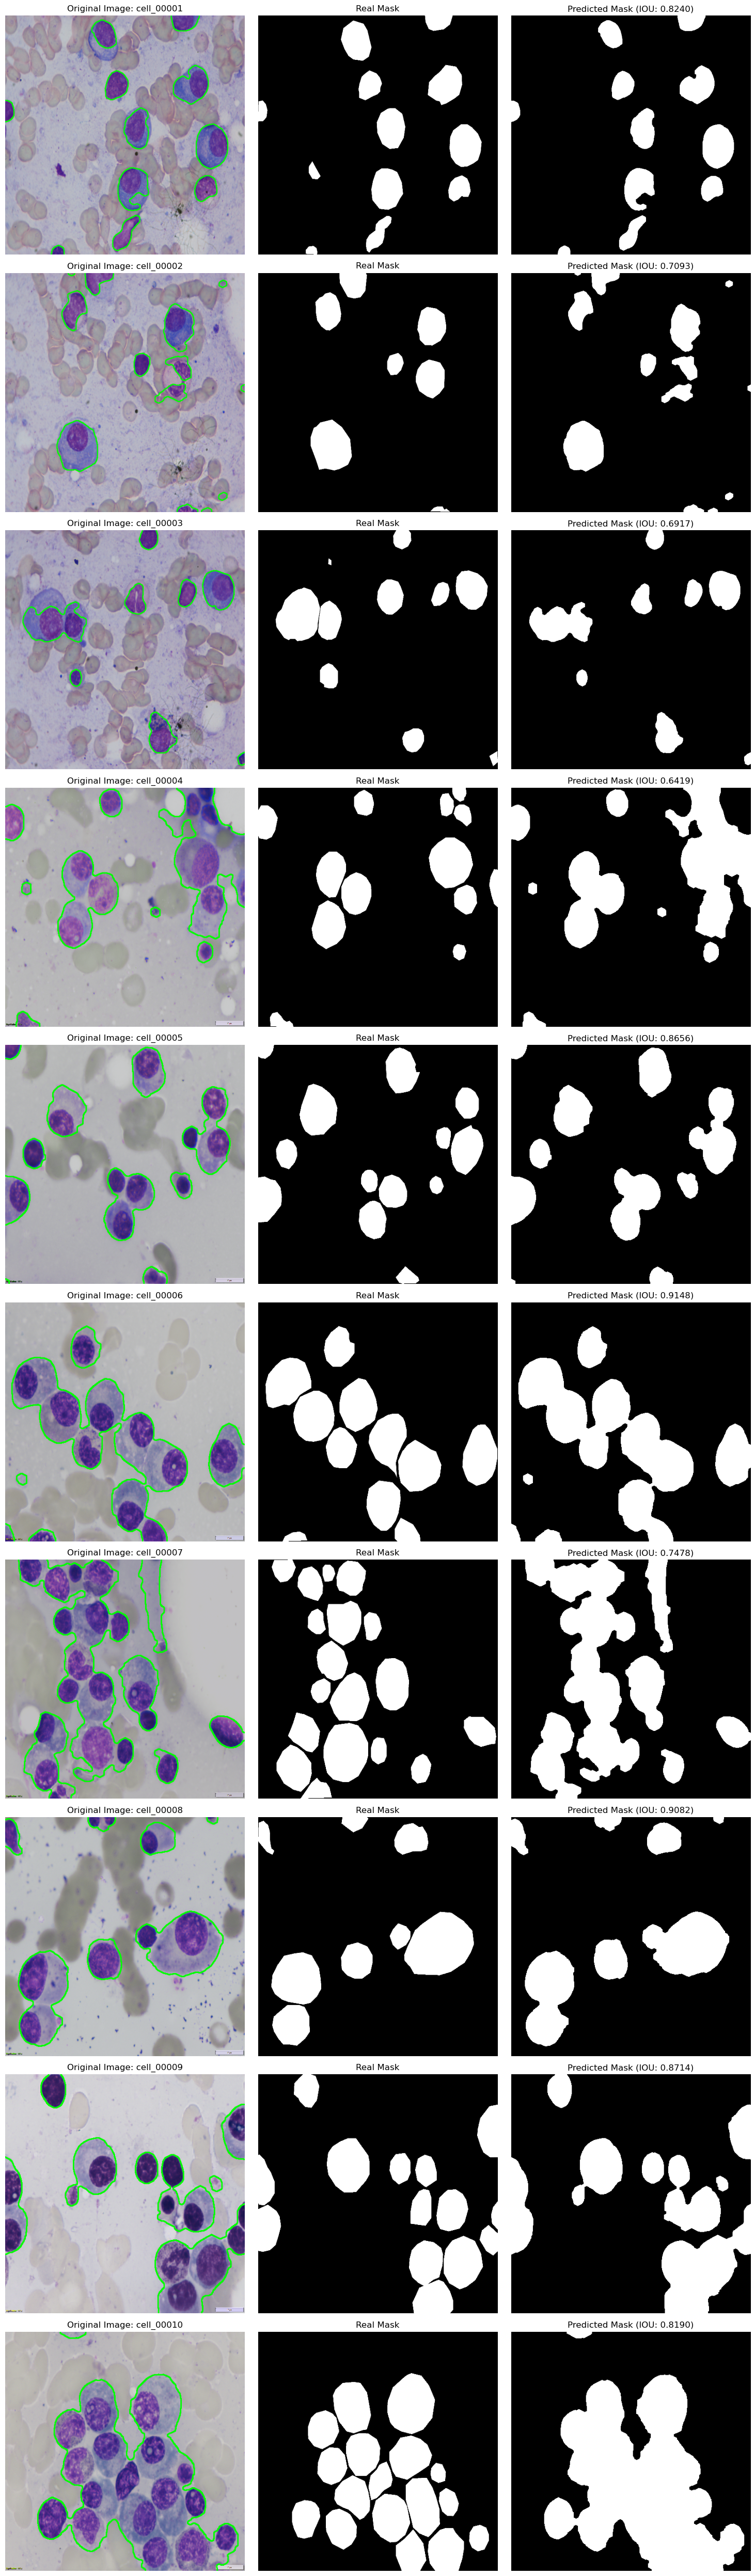

In [15]:
# Test için kullanılacak görüntü ve maske isimleri
image_names = [f"cell_000{str(i).zfill(2)}" for i in range(1, 11)]

# Görselleştirme
fig, axes = plt.subplots(len(image_names), 3, figsize=(15, 5 * len(image_names)))

# IOU hesaplama ve ortalamayı bulma
iou_scores = []

for idx, img_name in enumerate(image_names):
    mask_path = f"DB\\{img_name}.png"
    image_path = f"DB\\{img_name}.bmp"

    real_mask = cv2.imread(mask_path)
    real_mask = resize_img(real_mask)

    predicted_mask = cellDetection(image_path)  

    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image = resize_img(original_image)

    score = iou(predicted_mask, real_mask)
    iou_scores.append(score)
    print(f"{img_name} için IOU: {score:.4f}")


    # Maskenin boyutunu orijinal resimle uyumlu hale getir
    mask_resized = cv2.resize(predicted_mask, (original_image.shape[1], original_image.shape[0]))

    # Maskeyi orijinal resme uygula
    masked_image = cv2.bitwise_and(original_image, original_image, mask=mask_resized)

    # Kenarları tespit et (Canny yöntemiyle)
    edges = cv2.Canny(mask_resized, 100, 200)

    # Kenarları orijinal resim üzerinde çiz
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = original_image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)  # Yeşil renk ile kenarları çiz


    # Görüntüleri görselleştirme
    axes[idx, 0].imshow(image_with_contours)
    axes[idx, 0].set_title(f"Original Image: {img_name}")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(real_mask)
    axes[idx, 1].set_title("Real Mask")
    axes[idx, 1].axis("off")

    axes[idx, 2].imshow(predicted_mask, cmap = "gray")
    axes[idx, 2].set_title("Predicted Mask" + f" (IOU: {score:.4f})")
    axes[idx, 2].axis("off")

average_iou = np.mean(iou_scores)
print(f"\nOrtalama IOU: {average_iou:.4f}")

# Alt grafikler arasında boşluk bırakma
plt.tight_layout()
plt.show()